This dataset is a snapshot of the OpenPowerlifting database as of January 2024. OpenPowerlifting is creating a public-domain archive of powerlifting history. Powerlifting is a sport in which competitors compete to lift the most weight for their class in three separate barbell lifts: the Squat, Bench, and Deadlift.
source: https://www.kaggle.com/datasets/open-powerlifting/powerlifting-database

This workbook explores the Age, Bodyweight, Max Deadlift, Max Squat and Max Bench of the participants and the relationship between Max Squat and Max Deadlift. 
- Is there a strong correlation between the squat and deadlift?
- How much is the effect of the squat on the deadlift?

It would be interesting to see if there is a linear relationship between a squat and a deadlift. Would it be possible to substitute deadlifts with squats in a training program? 

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

# Import data

To reduce the size of the dataframe, only some columns are selected and the smallest possible data type is chosen to represent the data.

In [2]:
type_table = {'Age': np.float32,
             'BodyweightKg': np.float32,
             'Best3SquatKg': np.float32,
             'Best3BenchKg': np.float32,
             'Best3DeadliftKg': np.float32}

In [3]:
cols = ['Sex', 
        'Name',
        'BodyweightKg',
        'Age',
        'Equipment',
        'Best3DeadliftKg',
        'Best3SquatKg',
        'Best3BenchKg'
       ]

In [4]:
df = pd.read_csv('/home/blue/.datasets/openpowerlifting.csv',
                usecols=cols,
                low_memory= False,
                dtype=type_table
                )

In [5]:
df.head()

,Name,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
0,Abbie Murphy,F,Wraps,29.0,59.799999,105.0,55.0,130.0
1,Abbie Tuong,F,Wraps,29.0,58.500000,120.0,67.5,145.0
2,Ainslee Hooper,F,Raw,40.0,55.400002,NaN,32.5,NaN
3,Amy Moldenhauer,F,Wraps,23.0,60.000000,105.0,72.5,132.5
4,Andrea Rowan,F,Wraps,45.0,104.000000,140.0,80.0,170.0


In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Name             1423354 non-null  object 
 1   Sex              1423354 non-null  object 
 2   Equipment        1423354 non-null  object 
 3   Age              757527 non-null   float32
 4   BodyweightKg     1406622 non-null  float32
 5   Best3SquatKg     1031450 non-null  float32
 6   Best3BenchKg     1276181 non-null  float32
 7   Best3DeadliftKg  1081808 non-null  float32
dtypes: float32(5), object(3)
memory usage: 290.9 MB


# Prepare dataframe

In [7]:
df.rename(columns={'Best3SquatKg': 'MaxSquat',
                   'Best3BenchKg': 'MaxBench',
                   'Best3DeadliftKg': 'MaxDeadlift'},
          inplace=True)

In [8]:
df.describe()

,Age,BodyweightKg,MaxSquat,MaxBench,MaxDeadlift
count,757527.000000,1.406622e+06,1.031450e+06,1.276181e+06,1.081808e+06
mean,31.501577,8.422502e+01,1.740049e+02,1.165444e+02,1.872585e+02
std,13.369736,2.320970e+01,6.922947e+01,5.481014e+01,6.231248e+01
min,0.000000,1.510000e+01,-4.775000e+02,-5.225000e+02,-4.100000e+02
25%,21.000000,6.670000e+01,1.224700e+02,7.484000e+01,1.383500e+02
50%,28.000000,8.180000e+01,1.678300e+02,1.111300e+02,1.850000e+02
75%,40.000000,9.915000e+01,2.175000e+02,1.500000e+02,2.300000e+02
max,97.000000,2.580000e+02,5.750000e+02,4.885000e+02,5.850000e+02


The `describe()` method is used here to check if there are inconsistencies in the (numerical) data.

Failed attempts are indicated by multiplying the weight of the attempt by negative one.

For example, a failed attempt of 477.5KG Squat is indicated as -477.5KG.

Failed attempts will be removed in the analysis.

In [9]:
# Missing values as a percentage
df.isna().sum(axis=0) / len(df.index) * 100

Name             0.000000
Sex              0.000000
Equipment        0.000000
Age             46.778735
BodyweightKg     1.175533
MaxSquat        27.533839
MaxBench        10.339873
MaxDeadlift     23.995858
dtype: float64

There are missing values because not all events are identical. Some events consists only of one event (E.g Deadlift only), while others are combinations of two of events (E.g Squat and Deadlift). To simplify the analysis and get a more accurate correlation, missing values for BodyweightKg, MaxSquat, MaxBench and MaxDeadlift are removed. Missing values for Age is retained since 46% are missing.

OpenPowerlifting collects data from multiple competitions. Consequently, there will be records of the same lifter who has competed in multiple competitions. Thus, it is not possible to use a lifter as an index as doing so will result in error when attempting to plot the data. It is better to keep each record as a lifter may improve from competition to competition.

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
mask = ((df['Sex'] == 'M') &
        (df['Equipment'] == 'Raw') &
        (df['BodyweightKg'] > 0) &
        (df['MaxSquat'] > 0) &
        (df['MaxBench'] > 0) &
        (df['MaxDeadlift'] > 0)
        )

df = df[mask]

# Analysis

In [12]:
df.head()

,Name,Sex,Equipment,Age,BodyweightKg,MaxSquat,MaxBench,MaxDeadlift
41,Adrian Zwaan,M,Raw,80.0,82.099998,100.0,72.5,145.0
49,Ben Hales,M,Raw,31.0,98.599998,187.5,115.0,207.5
54,Brady Curtin,M,Raw,21.0,88.099998,170.0,115.0,225.0
74,Griffin Spence,M,Raw,27.0,67.099998,182.5,107.5,245.0
84,Jim Collins,M,Raw,72.0,82.500000,105.0,75.0,165.0


In [13]:
df.describe()

,Age,BodyweightKg,MaxSquat,MaxBench,MaxDeadlift
count,138486.000000,179467.000000,179467.000000,179467.000000,179467.000000
mean,28.989830,90.066032,189.027649,128.675583,220.629837
std,12.003319,19.778135,48.130554,33.196053,46.065224
min,5.000000,17.690001,7.500000,5.000000,5.600000
25%,20.500000,75.400002,160.000000,107.500000,192.500000
50%,25.000000,88.500000,187.500000,127.500000,220.000000
75%,33.500000,101.099998,220.000000,150.000000,250.000000
max,93.500000,233.000000,490.000000,322.500000,440.000000


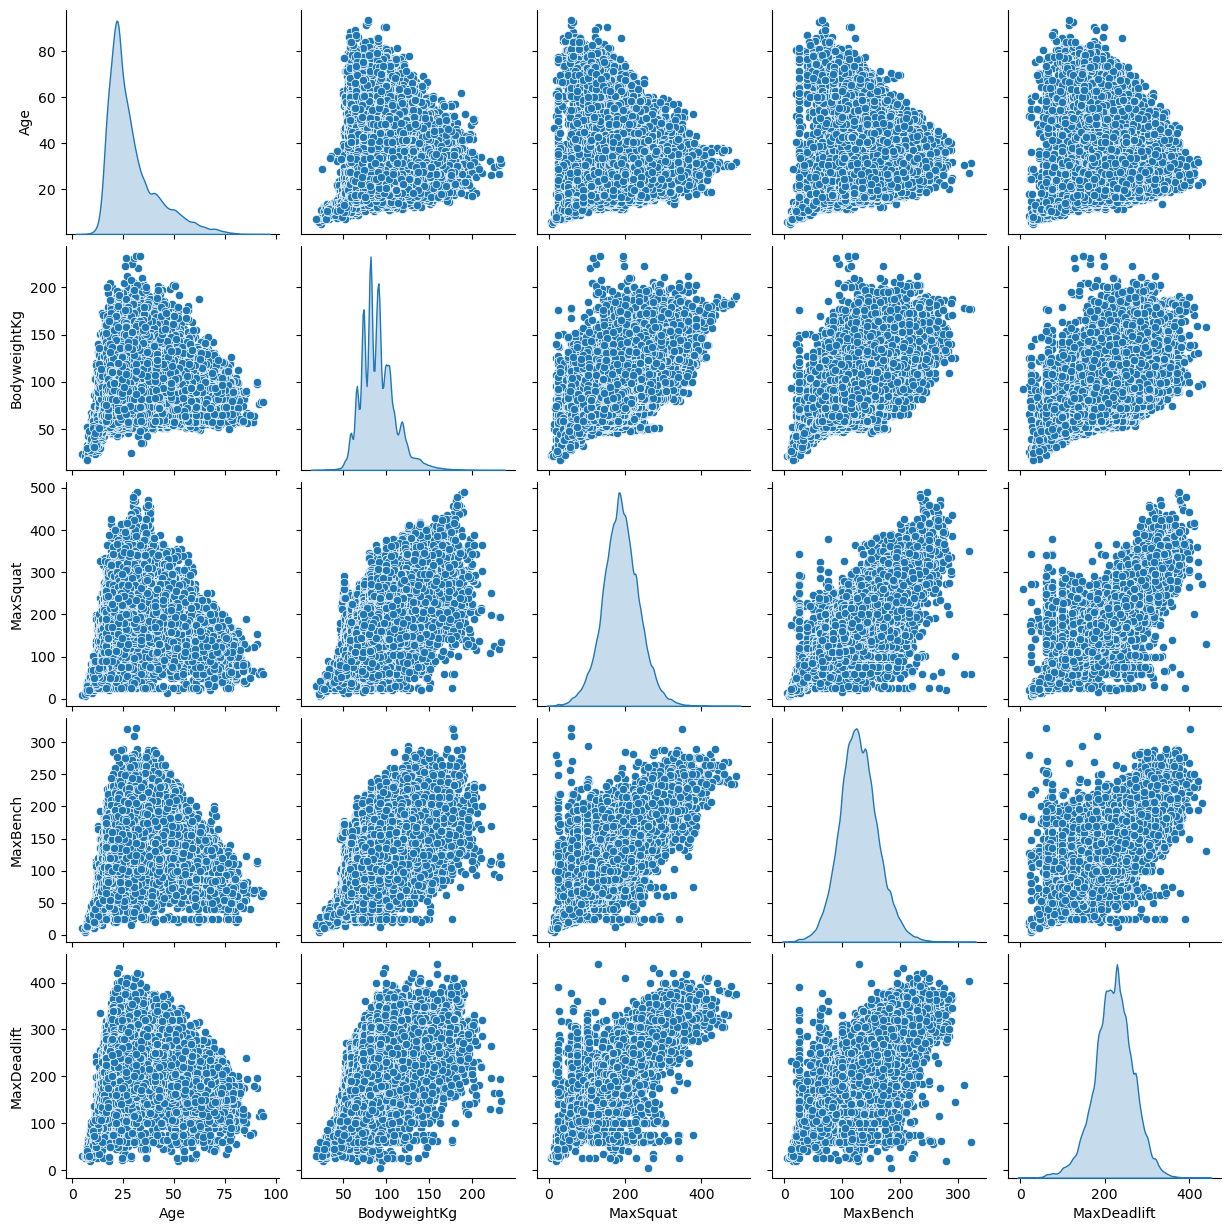

In [14]:
sns.pairplot(df, diag_kind='kde')

The distribution for the three lifts - `MaxSquat`, `MaxBench`, `MaxDeadlift` - approximates a normal distribution.
The distribution for `Age` is skewed to the right.
The shape of KDE plot of the distribution for `BodyweightKg` does not look smooth. This is because the lifters are competing in weight classes and most try gain as much weight as possible in their respective weight class to be competitive.

### Helper functions to plot

In [15]:
def plot_distribution(data, column, *, title, xlabel, center):
    fig, ax = plt.subplots()
    ax.hist(df[column], bins=40, color='pink', edgecolor='k')
    fig.suptitle(title, fontsize=16)
    if center == 'median':
        ax.axvline(df[column].median(), c='red', ls='--', ymax=.95, label=f'Median: {df[column].median():.1f}')
    elif center == 'mean':
        ax.axvline(df[column].mean(), c='red', ls='--', ymax=.95, label=f'Mean: {df[column].mean():.1f}')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    ax.set_xlabel(xlabel)

    plt.tight_layout()
    plt.show()

In [16]:
def plot_boxplot(data, column, *, title, xlabel, xticks):
    box = sns.boxplot(data=data, x=column, color='.8', linewidth=.75, fliersize=.9)
    box.set_title(title)
    box.set_xlabel(xlabel)
    box.set_xticks(xticks)
    box.spines['top'].set_visible(False)
    box.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_cumulative_histogram(data,
                             column,
                             *,
                             bin_range,
                             title,
                             xlabel):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.hist(df[column],
            bins=bin_range,
            color='pink',
            edgecolor='k',
            cumulative=True,
            density=True,
            alpha=.8
           )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks(bin_range)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Probability of Occurence')

    plt.tight_layout()
    plt.show()

## Univariate analysis of each variable

### Participants' Age

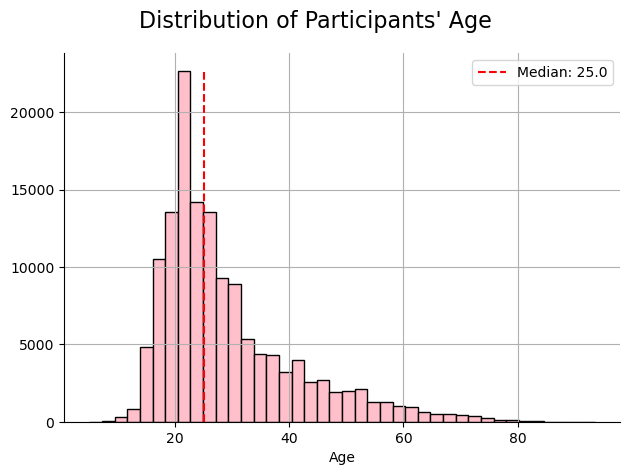

In [18]:
plot_distribution(df,
                  'Age',
                  title="Distribution of Participants' Age",
                  xlabel='Age',
                  center='median'
                 )

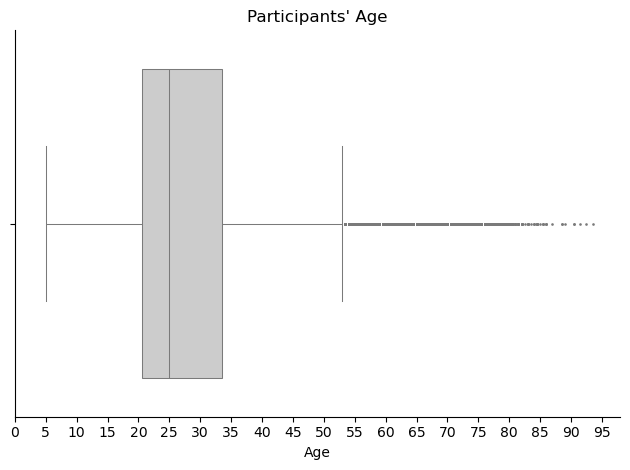

In [19]:
plot_boxplot(df,
             'Age',
             title="Participants' Age",
             xlabel='Age',
             xticks=list(range(0,100,5))
            )

In [20]:
df['Age'].describe()

count    138486.000000
mean         28.989830
std          12.003319
min           5.000000
25%          20.500000
50%          25.000000
75%          33.500000
max          93.500000
Name: Age, dtype: float64

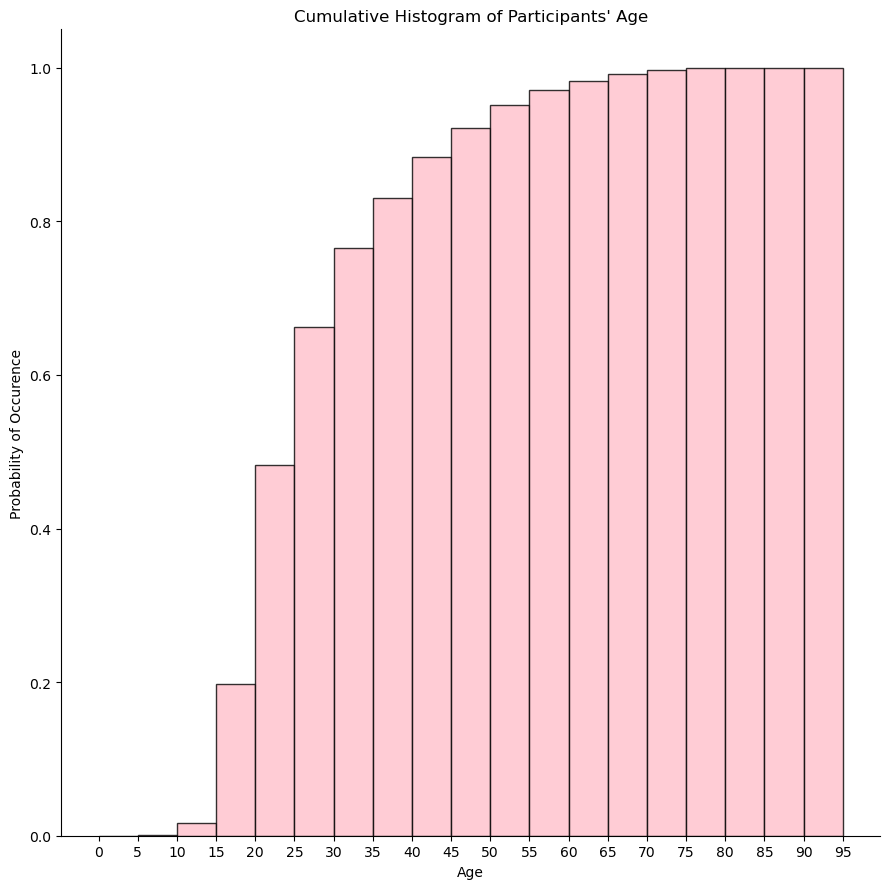

In [21]:
plot_cumulative_histogram(df,
                          'Age',
                          bin_range=list(range(0, 100, 5)),
                          title="Cumulative Histogram of Participants' Age",
                          xlabel='Age')

A lifter can estimate his competitive years by looking at the age range of the competition and plan his strength training program accordingly.

75% of the participants are younger than or equal to 33.5 years old.

Hence, it is good to have an experienced coach to oversee a training program in order to not waste time and potential as well as to avoid injuries.

### Bodyweight (KG)

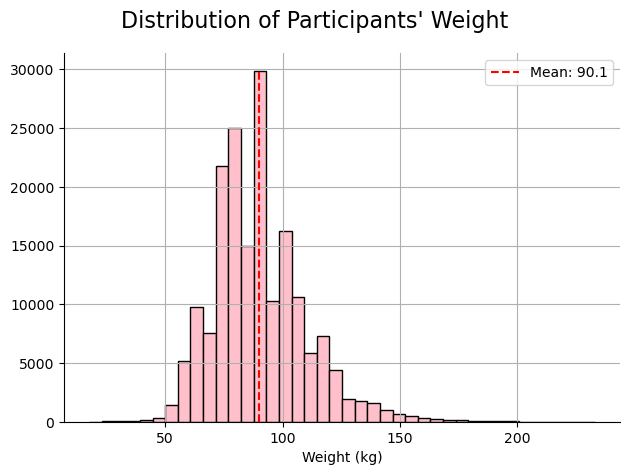

In [22]:
plot_distribution(df,
                  'BodyweightKg',
                  title="Distribution of Participants' Weight",
                  xlabel="Weight (kg)",
                  center='mean'
                 )

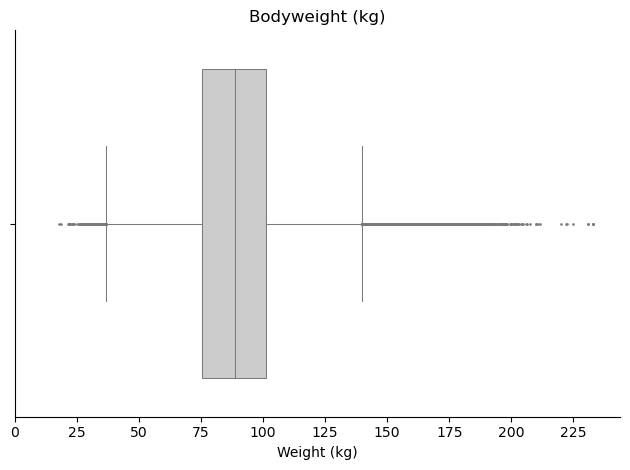

In [23]:
plot_boxplot(df, 
             'BodyweightKg', 
             title='Bodyweight (kg)',
             xlabel='Weight (kg)',
             xticks=(list(range(0, 250, 25)))
            )

In [24]:
df['BodyweightKg'].describe()

count    179467.000000
mean         90.066032
std          19.778135
min          17.690001
25%          75.400002
50%          88.500000
75%         101.099998
max         233.000000
Name: BodyweightKg, dtype: float64

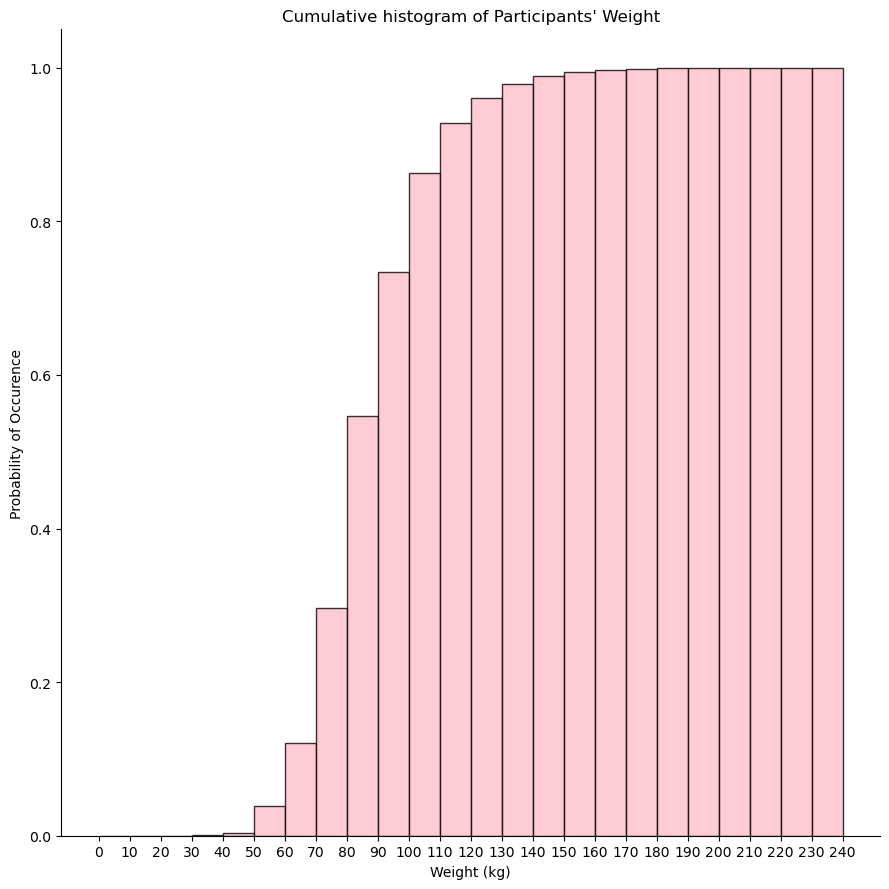

In [25]:
plot_cumulative_histogram(df,
                          'BodyweightKg',
                          bin_range=list(range(0, 250, 10)),
                          title="Cumulative histogram of Participants' Weight",
                          xlabel=('Weight (kg)')
                         )

### Bench Press

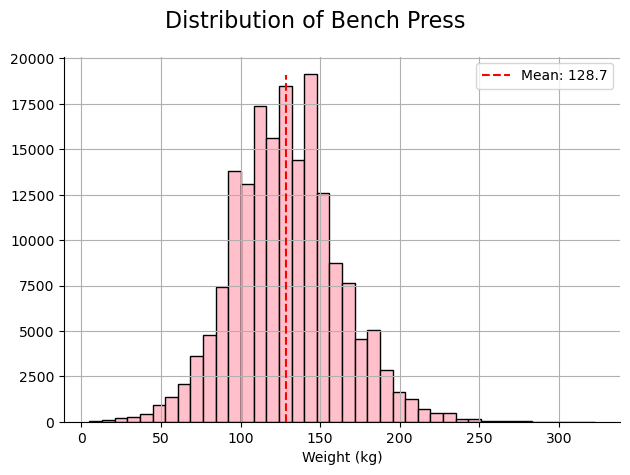

In [26]:
plot_distribution(df,
                  'MaxBench',
                  title='Distribution of Bench Press',
                  xlabel='Weight (kg)',
                  center='mean'
                 )

In [27]:
df['MaxBench'].describe()

count    179467.000000
mean        128.675583
std          33.196053
min           5.000000
25%         107.500000
50%         127.500000
75%         150.000000
max         322.500000
Name: MaxBench, dtype: float64

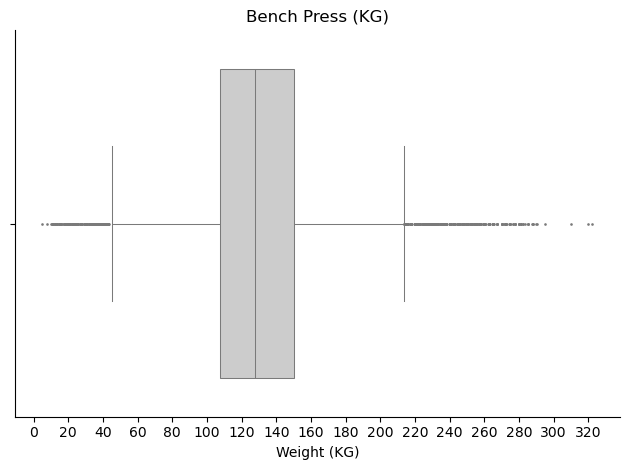

In [28]:
plot_boxplot(df,
            'MaxBench',
             title='Bench Press (KG)',
             xlabel='Weight (KG)',
             xticks=list(range(0,325,20))
            )

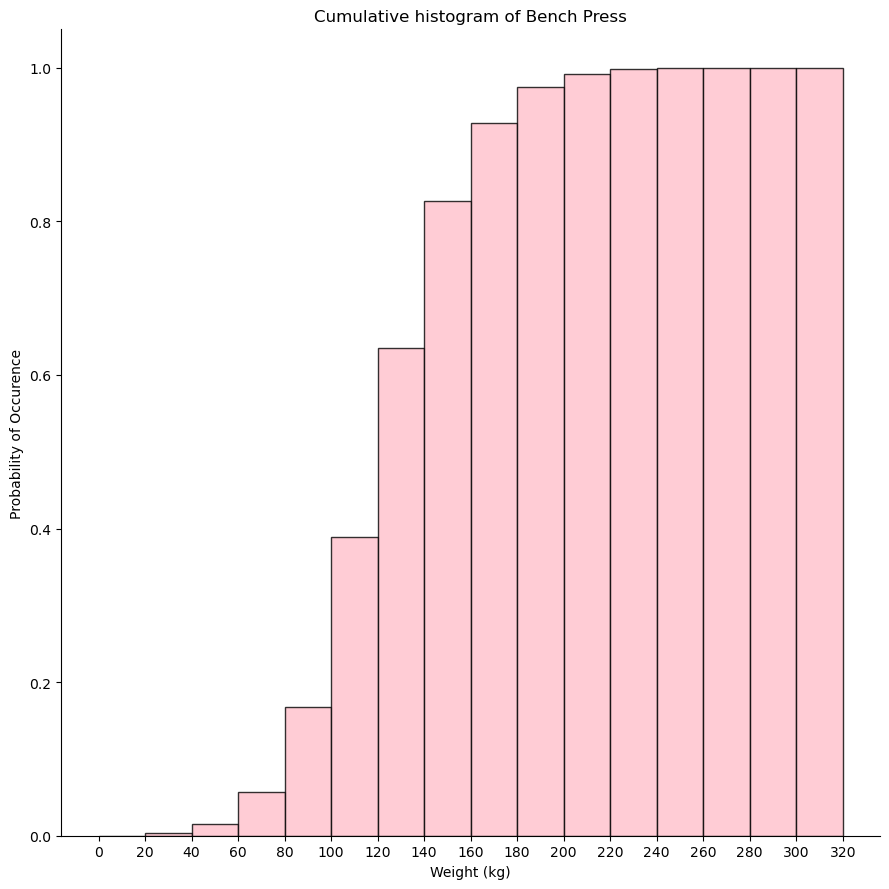

In [29]:
plot_cumulative_histogram(df,
                          'MaxBench',
                          bin_range=list(range(0, 325, 20)),
                          title="Cumulative histogram of Bench Press",
                          xlabel=('Weight (kg)')
                         )

### Squat

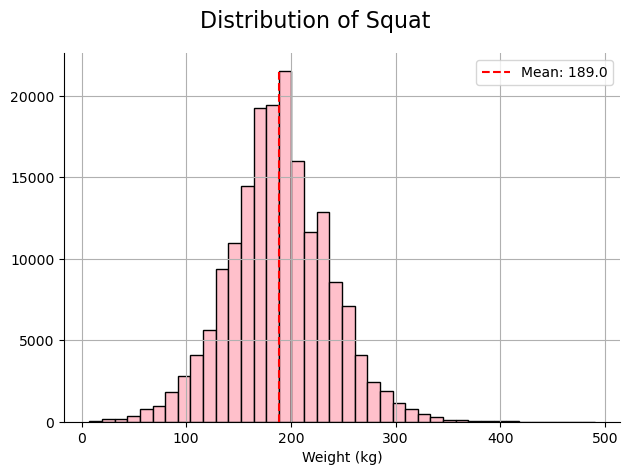

In [30]:
plot_distribution(df,
                  'MaxSquat',
                  title='Distribution of Squat',
                  xlabel='Weight (kg)',
                  center='mean'
                 )

In [31]:
df['MaxSquat'].describe()

count    179467.000000
mean        189.027649
std          48.130554
min           7.500000
25%         160.000000
50%         187.500000
75%         220.000000
max         490.000000
Name: MaxSquat, dtype: float64

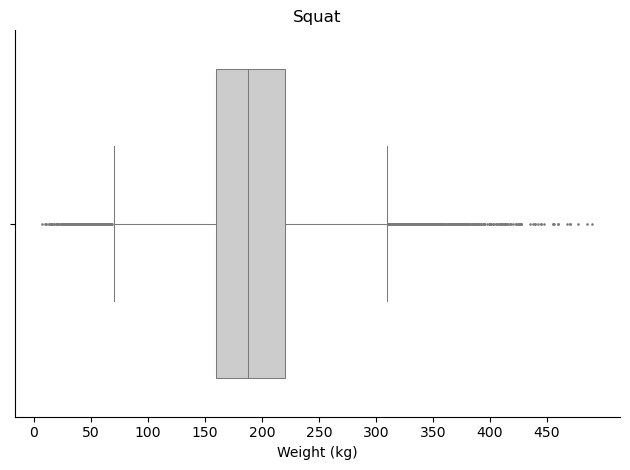

In [32]:
plot_boxplot(df,
            'MaxSquat',
             title='Squat',
             xlabel='Weight (kg)',
             xticks=list(range(0,500,50))
            )

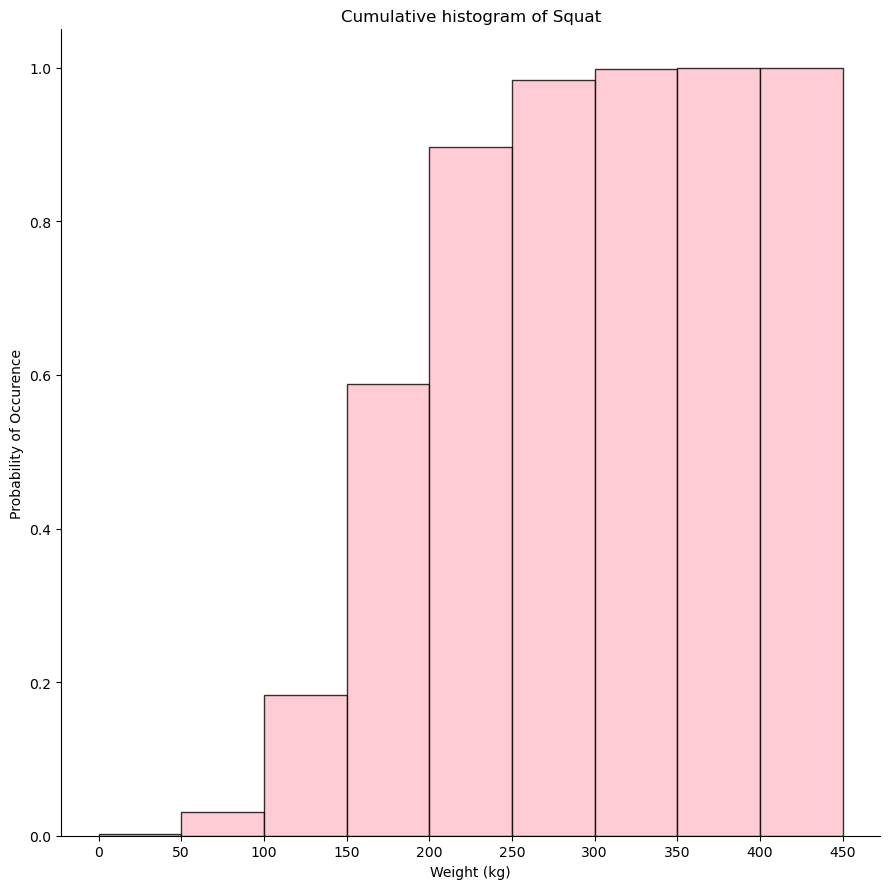

In [33]:
plot_cumulative_histogram(df,
                          'MaxSquat',
                          bin_range=list(range(0, 500, 50)),
                          title="Cumulative histogram of Squat",
                          xlabel=('Weight (kg)')
                         )

### Deadlift

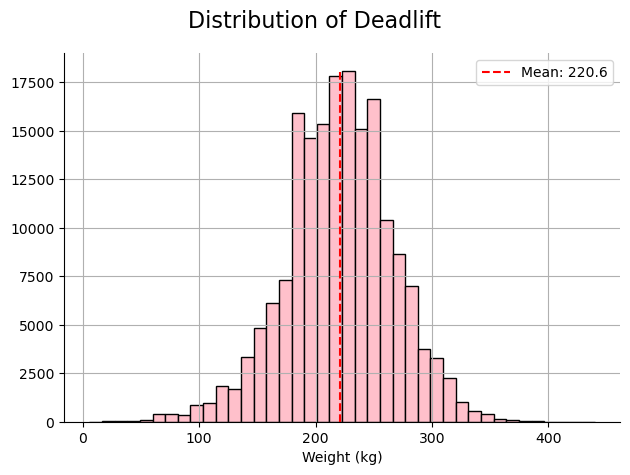

In [34]:
plot_distribution(df,
                  'MaxDeadlift',
                  title='Distribution of Deadlift',
                  xlabel='Weight (kg)',
                  center='mean'
                 )

In [35]:
df['MaxDeadlift'].describe()

count    179467.000000
mean        220.629837
std          46.065224
min           5.600000
25%         192.500000
50%         220.000000
75%         250.000000
max         440.000000
Name: MaxDeadlift, dtype: float64

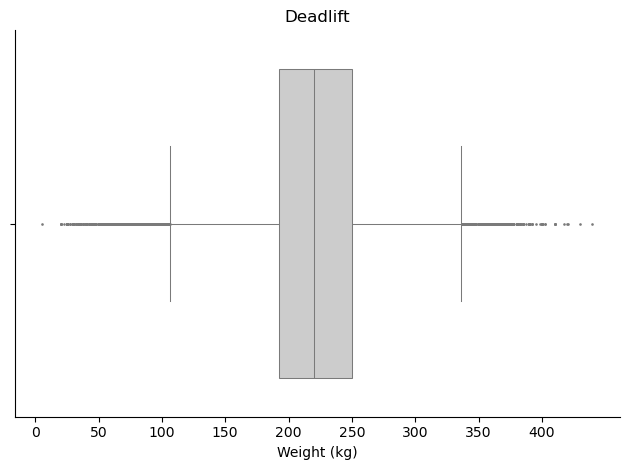

In [36]:
plot_boxplot(df,
            'MaxDeadlift',
             title='Deadlift',
             xlabel='Weight (kg)',
             xticks=list(range(0,450,50))
            )

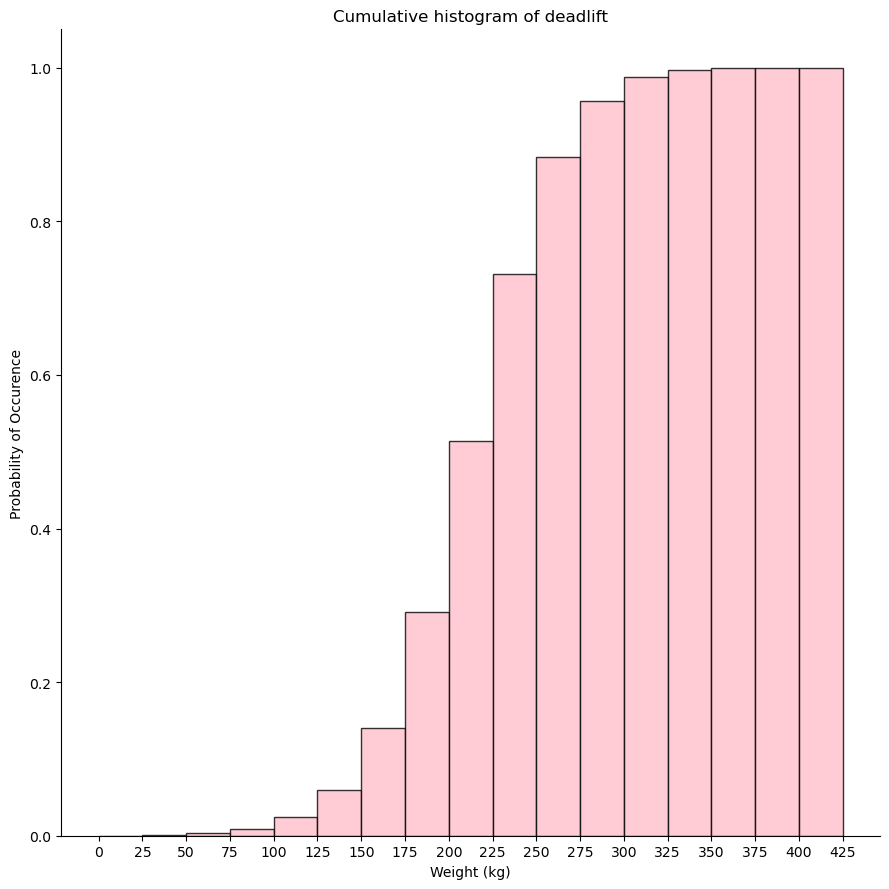

In [37]:
plot_cumulative_histogram(df,
                          'MaxDeadlift',
                          bin_range=list(range(0, 450, 25)),
                          title='Cumulative histogram of deadlift',
                          xlabel=('Weight (kg)')
                         )

## Bivariate analysis


<Axes: >

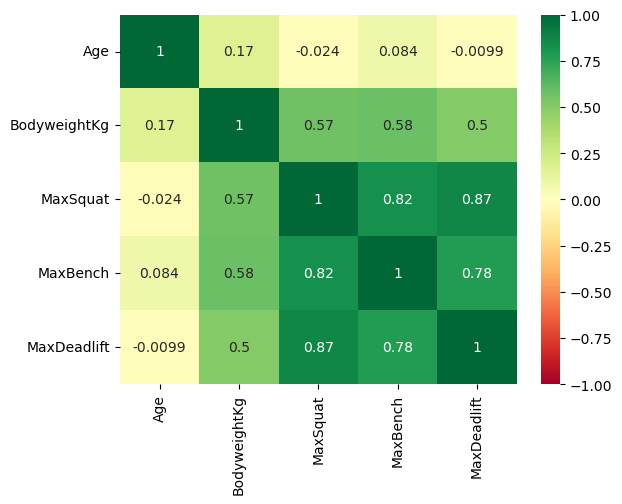

In [38]:
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='RdYlGn')

In [39]:
df.corr(numeric_only=True)

,Age,BodyweightKg,MaxSquat,MaxBench,MaxDeadlift
Age,1.000000,0.169245,-0.024333,0.083808,-0.009950
BodyweightKg,0.169245,1.000000,0.565227,0.579735,0.502678
MaxSquat,-0.024333,0.565227,1.000000,0.822273,0.869942
MaxBench,0.083808,0.579735,0.822273,1.000000,0.777113
MaxDeadlift,-0.009950,0.502678,0.869942,0.777113,1.000000


In [40]:
pr, pvalue = stats.pearsonr(df['MaxSquat'], df['MaxDeadlift'])
print(f'Pearson correlation coefficient: {pr:.2f}')
print(f'P-value: {pvalue}')

Pearson correlation coefficient: 0.87
P-value: 0.0


There is a strong positive correlation between Squat and Deadlift.

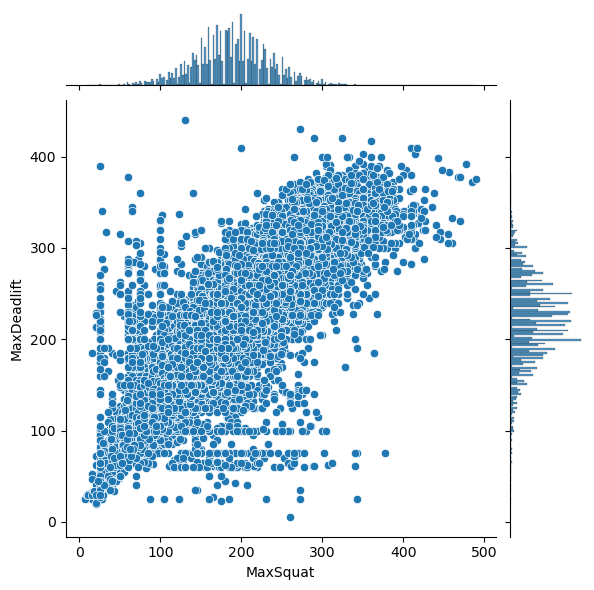

In [41]:
sns.jointplot(data=df, x='MaxSquat', y='MaxDeadlift')

## Model

In [42]:
X = df[['MaxSquat']].values
y = df['MaxDeadlift'].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [44]:
regressor = LinearRegression(fit_intercept=True)
regressor.fit(X_train, y_train)

LinearRegression()

In [45]:
print(f'Model Intercept: {regressor.intercept_}')
print(f'Model Coefficient: {regressor.coef_}')

Model Intercept: 63.315673828125
Model Coefficient: [0.83228797]


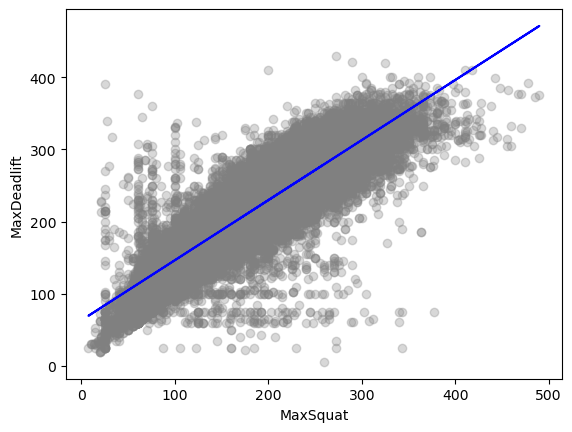

In [46]:
plt.scatter(X_train, y_train, color='grey', alpha=.3)
plt.plot(X_train, regressor.predict(X_train), color='blue')
plt.xlabel('MaxSquat')
plt.ylabel('MaxDeadlift')
plt.show()

In [47]:
y_pred = regressor.predict(X_test)

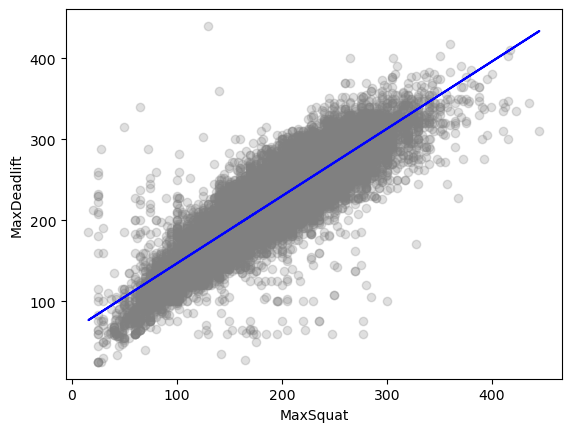

In [48]:
plt.scatter(X_test, y_test, color='grey', alpha=.25)
plt.plot(X_test, y_pred, color='blue')
plt.xlabel('MaxSquat')
plt.ylabel('MaxDeadlift')
plt.show()

In [49]:
r2_score(y_test, y_pred)

0.759278634946704

This means that about 76% of the variation in the data is explained by the MaxSquat and MaxDeadlift relationship.

In [50]:
root_mean_squared_error(y_test, y_pred)

22.581806

In [51]:
squat = [x for x in range(20, 140+1, 10)]
pred_deadlift = regressor.predict(np.array([x for x in range(20, 140+1, 10)]).reshape(-1,1))
pred_df = pd.DataFrame({'Squat': squat, 'Predicted_Deadlift': pred_deadlift})

In [52]:
pred_df

,Squat,Predicted_Deadlift
0,20,79.961433
1,30,88.284313
2,40,96.607193
3,50,104.930072
4,60,113.252952
5,70,121.575832
6,80,129.898711
7,90,138.221591
8,100,146.544471
9,110,154.867350


# Conclusion

There is a strong positive correlation between MaxSquat and MaxDeadlift (r = 0.87, p=0.0).
The Simple Linear Regression model indicates that there is a 76% reduction in variance when we take MaxSquat into account (r2 = 0.759).
The result supports building a stronger squat to achieve a better deadlift.